In [1]:
import pandas as pd
import numpy as np 
import tensorflow
from tensorflow import keras
import re

In [2]:
df = pd.read_csv('IMDB Dataset.csv')

In [3]:
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [4]:
def rem_tags(text):
    cleaned = re.sub("<.*?>","",text)
    return cleaned

In [5]:
df["review"]=df["review"].apply(rem_tags)

In [6]:
df["review"]=df["review"].apply(lambda x:x.lower())

In [8]:
from nltk.corpus import stopwords

stopwords=stopwords.words("english")

In [9]:
def rem_stopwords(text):
    clean=[]
    for word in text.split():
        if word not in stopwords:
            clean.append(word)
    return " ".join(clean)

In [10]:
df["review"]=df["review"].apply(rem_stopwords)

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.duplicated().sum()

0

In [13]:
df["review"]=df["review"].apply(lambda x : x.replace('"',""))

In [14]:
df["review"]=df["review"].apply(lambda x : x.replace(',',""))

In [17]:
!pip install gensim
import gensim
from gensim.utils import simple_preprocess


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.0 MB 1.3 MB/s eta 0:00:19
   ---------------------------------------- 0.2/24.0 MB 3.0 MB/s eta 0:00:08
    --------------------------------------- 0.5/24.0 MB 3.9 MB/s eta 0:00:06
   - -------------------------------------- 0.8/24.0 MB 4.3 MB/s eta 0:00:06
   - -------------------------------------- 1.1/24.0 MB 4.9 MB/s eta 0:00:05
   -- ------------------------------------- 1.3/24.0 MB 4.7 MB/s eta 0:00:05
   -- ------------------------------------- 1.5/24.0 MB 4.9 MB/s eta 0:00:05
   -- ------------------------------------- 1.6/24.0 MB 4.5 MB/s eta 0:00:05
   --- ------------------------------------ 1.8/24.0 MB 4.5 MB/s eta 0:00:05
   --- ------------------------------------ 2.0/24.0 MB 4.5 MB/s eta 0:00:05
   --- ------------------------------------ 2.2/24.0 MB 4.5 MB/s eta 0:00:05
   --

In [34]:
def gensim_preprocess(text):
    cleaned=simple_preprocess(text)
    
    return cleaned


In [19]:
df["review"]=df["review"].apply(gensim_preprocess)

In [20]:
df["review"].sample(3)

29643    [absolutely, mesmerised, series, moment, tom, ...
14834    [worst, movie, ever, made, anyone, asks, worst...
19400    [said, would, film, greater, turks, fruit, dar...
Name: review, dtype: object

In [21]:
# now tokenize

from keras.preprocessing.text import Tokenizer

tok=Tokenizer()

In [22]:
x=df["review"]
y=df["sentiment"]

In [23]:
y=y.apply(lambda x: 1 if x=="positive" else 0)

In [24]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

In [25]:
tok.fit_on_texts(X_train)

In [26]:
len(tok.word_index)

96805

In [27]:
X_train = tok.texts_to_sequences(X_train)
X_test = tok.texts_to_sequences(X_test)

In [28]:
from keras.preprocessing.sequence import pad_sequences

In [29]:
X_train=pad_sequences(X_train,maxlen=100,padding="post")
X_test=pad_sequences(X_test,maxlen=100,padding="post")

In [30]:
from keras.layers import Dense,Embedding,LSTM
from keras.models import Sequential

In [31]:
model=Sequential()
model.add(Embedding(input_dim=len(tok.index_word)+1, output_dim=100,input_length=100))
model.add(LSTM(150))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9680600   
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 9831351 (37.50 MB)
Trainable params: 9831351 (37.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(X_train,y_train , epochs=10, batch_size=50, validation_split=0.2)

Epoch 1/10
635/635 [==============================] - 289s 445ms/step - loss: 0.4105 - accuracy: 0.8061 - val_loss: 0.3106 - val_accuracy: 0.8702
Epoch 2/10
635/635 [==============================] - 290s 456ms/step - loss: 0.1914 - accuracy: 0.9335 - val_loss: 0.3282 - val_accuracy: 0.8713
Epoch 3/10
635/635 [==============================] - 288s 453ms/step - loss: 0.0996 - accuracy: 0.9705 - val_loss: 0.3640 - val_accuracy: 0.8636
Epoch 4/10
635/635 [==============================] - 293s 461ms/step - loss: 0.0727 - accuracy: 0.9788 - val_loss: 0.3932 - val_accuracy: 0.8612
Epoch 5/10
635/635 [==============================] - 281s 442ms/step - loss: 0.0584 - accuracy: 0.9841 - val_loss: 0.4803 - val_accuracy: 0.8576
Epoch 6/10
635/635 [==============================] - 267s 420ms/step - loss: 0.0448 - accuracy: 0.9866 - val_loss: 0.4575 - val_accuracy: 0.8601
Epoch 7/10
635/635 [==============================] - 267s 421ms/step - loss: 0.0358 - accuracy: 0.9902 - val_loss: 0.5579 -

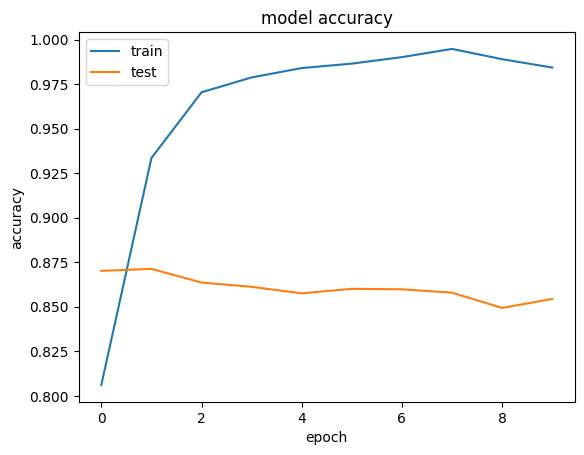

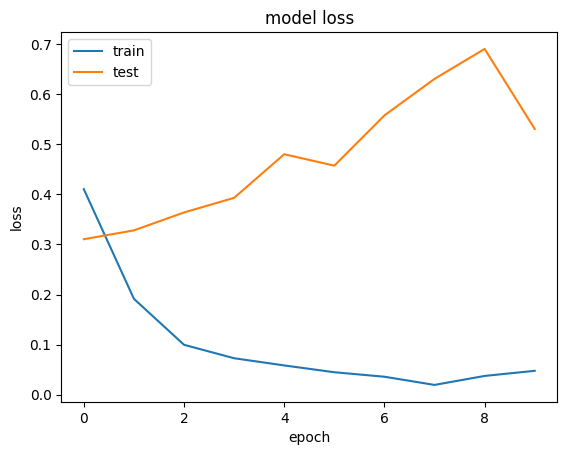

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [53]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the model
score = model.evaluate(X_train, y_train, verbose=1)
loss = score[0]
accuracy = score[1]

print("Loss:", loss)
print("Accuracy:", accuracy)

# Predict classes
y_pred_prob = model.predict(X_train)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

# Calculate other metrics
classification_rep = classification_report(y_train, y_pred)
print("Classification Report:\n", classification_rep)


1240/1240 [==============================] - 49s 40ms/step - loss: 0.1202 - accuracy: 0.9660
Loss: 0.120229572057724
Accuracy: 0.9660136699676514
1240/1240 [==============================] - 51s 41ms/step
Accuracy: 0.9660136651287093
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     19714
           1       0.97      0.96      0.97     19949

    accuracy                           0.97     39663
   macro avg       0.97      0.97      0.97     39663
weighted avg       0.97      0.97      0.97     39663

